# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  Carlos Castro   
__Class:__ MIDS w261 (Section 2, e.g., Fall 2016 Group 1)     
__Email:__  carlosscastro@iSchool.Berkeley.edu     
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


In [3]:
import sys
sys.version

'2.7.13 | packaged by conda-forge | (default, May  2 2017, 12:48:11) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5

Version 2017-9-2 


### IMPORTANT

This homework must be completed in the cloud 

### === INSTRUCTIONS for SUBMISSIONS ===   
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Click this link to enable you to create a github repo within the MIDS261 Classroom:   
https://classroom.github.com/assignment-invitations/3b1d6c8e58351209f9dd865537111ff8   
and follow the instructions to create a HW repo.

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

## MapReduce Classes

In [4]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import collections
import logging
import time



class MRbuildStripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
  
    MRJob.SORT_VALUES = True
    
    #def mapper_init(self):
    #    return self.start_time = time.time()
        
    def mapper(self, _, line):
        splits = line.rstrip("\n").split("\t")

        words = splits[0].lower().split()
        count = splits[1]

        H = {}
        for subset in itertools.combinations(sorted(set(words)), 2):
            
            # Process combinations in sorted order, i.e. "hello","tomorrow"
            if subset[0] not in H.keys():
                H[subset[0]] = {}
                H[subset[0]][subset[1]] = count 
            elif subset[1] not in H[subset[0]]:
                H[subset[0]][subset[1]] = count
            else:
                H[subset[0]][subset[1]] += count

            # Obtain combinations in reverse order, to consider them both ways
            # TODO: Should refactor this and the block above, shameless copy-paste
            if subset[1] not in H.keys():
                H[subset[1]] = {}
                H[subset[1]][subset[0]] = count 
            elif subset[0] not in H[subset[1]]:
                H[subset[1]][subset[0]] = count
            else:
                H[subset[1]][subset[0]] += count
        for key in H.keys():
            #print "%s\t%s" % (key, json.dumps(H[key]))
            yield key, H[key]

    def reducer(self, key, values):
        
        counter = {}

        for value in values:
            
            for k, v in value.iteritems():
                if k in counter:
                    counter[k] += int(v)
                else:
                    counter[k] = int(v)
        
        yield key, counter
        
    
    def steps(self):
        return [

            MRStep(#mapper_init=self.mapper_init
                   #,
                   mapper=self.mapper
                   ,
                   reducer=self.reducer
                  )
            ]
  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
    start_time = time.time()
    MRbuildStripes.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing buildStripes.py


In [5]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
import logging
import time

class MRinvertedIndex(MRJob):
    
    #START SUDENT CODE531_INV_INDEX
  
    def mapper(self, _, line):
        key, stripeJson = line.strip().split('\t')
        key = key.strip("\"")
        stripe = json.loads(stripeJson)
        
        for k, v in stripe.iteritems():
            yield k, [key, len(stripe)]
        
    def reducer(self, key, values):

        table = {}
        for value in values:
            table[value[0]] = value[1]
            
        yield key, table
        
    #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    start_time = time.time()
    MRinvertedIndex.run() 
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing invertedIndex.py


In [6]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
#import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import time
import logging

class MRsimilarity(MRJob):
  
    #START SUDENT CODE531_SIMILARITY

    MRJob.SORT_VALUES = True
    
    def mapper(self, _, line):
        key, valuesJson = line.strip().split('\t')
        key = key.strip("\"")
        values = json.loads(valuesJson)

        for pair in itertools.combinations(sorted(set(values)), 2):
            yield pair, [values[pair[0]], values[pair[1]]]
        
    def reducer(self, key, values):
        intersection = 0
        count1 = None
        count2 = None
        
        cosine = 0.0
        
        # Iterate through the values
        for value in values:
            # Jaccard, get counts for the intersection, and for each set
            intersection += 1
            if count1 == None:
                count1 = value[0]
                count2 = value[1]
        
            # Cosine
            a = 1 / math.sqrt(value[0])
            b = 1 / math.sqrt(value[1])
            cosine += a * b
            
        jaccard = float(intersection) / float(count1 + count2 - intersection)
        
        overlap_coefficient = float(intersection) / min(count1, count2)
        
        dice_coefficient = float(2 * intersection) / (count1 + count2)
        
        average = (cosine + jaccard + overlap_coefficient + dice_coefficient) / 4.0
        
        yield average, [key[0] + ' - ' + key[1], cosine, jaccard, overlap_coefficient, dice_coefficient]
            
    #END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    start_time = time.time()
    MRsimilarity.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing similarity.py


## Mini-test data

In [7]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Writing googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


In [8]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Writing atlas-boon-systems-test.txt


## Build stripes for mini-test data

In [9]:
###########################################################################
# Make Stripes from ngrams for systems test 1
###########################################################################

!hdfs dfs -rm -r systems_test_stripes_1
!python buildStripes.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1

rm: `systems_test_stripes_1': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.nhaas.20170620.004317.534010
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/buildStripes.nhaas.20170620.004317.534010/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-stream

### Stripes on Mini-Test Data Statistics:

#### Time
* _Run time: 53.6 seconds_

* _Run time: 0.89 minutes_

#### Input/Output statistics
* _Bytes Read: 563_

* _Bytes Written: 2046_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2440_ 

In [11]:
!cat systems_test_stripes_1

"a"	{"limited": 55, "female": 447, "general": 92, "sea": 62, "in": 1201, "religious": 59, "george": 92, "biography": 92, "city": 62, "for": 59, "tales": 123, "child's": 1099, "forms": 116, "wales": 1099, "christmas": 1099, "government": 102, "collection": 239, "by": 62, "case": 604, "circumstantial": 62, "fairy": 123, "of": 895, "study": 604, "bill": 59, "establishing": 59, "narrative": 62, "the": 124}
"bill"	{"a": 59, "religious": 59, "for": 59, "establishing": 59}
"biography"	{"a": 92, "of": 92, "george": 92, "general": 92}
"by"	{"a": 62, "city": 62, "the": 62, "sea": 62}
"case"	{"a": 604, "limited": 55, "government": 102, "of": 502, "study": 604, "female": 447, "in": 102}
"child's"	{"a": 1099, "wales": 1099, "christmas": 1099, "in": 1099}
"christmas"	{"a": 1099, "wales": 1099, "in": 1099, "child's": 1099}
"circumstantial"	{"a": 62, "of": 62, "the": 62, "narrative": 62}
"city"	{"a": 62, "the": 62, "by": 62, "sea": 62}
"collection"	{"a": 239, "forms": 116, "fairy": 123, "tales": 123, 

In [12]:
###########################################################################
# Make Stripes from ngrams for systems test 2
###########################################################################

!hdfs dfs -rm -r systems_test_stripes_2
!python buildStripes.py -r hadoop atlas-boon-systems-test.txt > systems_test_stripes_2

rm: `systems_test_stripes_2': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.nhaas.20170620.004413.890907
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/buildStripes.nhaas.20170620.004413.890907/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-stream

### Stripes on System Test 2 Statistics:

#### Time
* _Run time: 132.3 seconds_

* _Run time: 2.2 minutes_

#### Input/Output statistics
* _Bytes Read: 138_

* _Bytes Written: 98029_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 3390_ 

In [14]:
!cat systems_test_stripes_2

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


In [15]:
########################################################################
# Stripes for systems test 3 (given, no need to build stripes)
########################################################################

with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3  

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


## Inverted indices for mini-test data

In [16]:
!python invertedIndex.py -r hadoop systems_test_stripes_1 > systems_test_index_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.nhaas.20170620.004627.008403
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/invertedIndex.nhaas.20170620.004627.008403/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7687580488355699665.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to R

### Inverted Indicies on Mini-Test Data Statistics:

#### Time
* _Run time: 54.2 seconds_

* _Run time: 0.9 minutes_

#### Input/Output statistics
* _Bytes Read: 3609_

* _Bytes Written: 2192_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2680_ 

In [18]:
!python invertedIndex.py -r hadoop systems_test_stripes_2 > systems_test_index_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.nhaas.20170620.004721.521416
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/invertedIndex.nhaas.20170620.004721.521416/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5550599406287433497.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to R

### Inverted Indicies on System Test 2 Statistics:

#### Time
* _Run time: 62.4 seconds_

* _Run time: 1.04 minutes_

#### Input/Output statistics
* _Bytes Read: 245_

* _Bytes Written: 153_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 3090_ 

In [20]:
!python invertedIndex.py -r hadoop systems_test_stripes_3 > systems_test_index_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.nhaas.20170620.004824.273211
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/invertedIndex.nhaas.20170620.004824.273211/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8157236064607760792.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to R

### Inverted Indicies on System Test 3 Statistics:

#### Time
* _Run time: 56.76 seconds_

* _Run time: 0.95 minutes_

#### Input/Output statistics
* _Bytes Read: 140_

* _Bytes Written: 124_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2770_

In [22]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################
import json

for i in range(1,4):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("systems_test_index_"+str(i),"r") as f:
        lines = sorted(f.readlines())
        for line in lines:
            line = line.strip()
            word, doc_list = line.split("\t")
            doc_dict = json.loads(doc_list)
            stripe=[]
            for doc in doc_dict:
                stripe.append([doc, doc_dict[doc]])
            stripe=sorted(stripe)
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format(
              (word), stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))

————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
             "a" |          bill 4 |     biography 4 |            by 4
          "bill" |            a 27 |  establishing 4 |           for 4
     "biography" |            a 27 |       general 4 |        george 4
            "by" |            a 27 |          city 4 |           sea 4
          "case" |            a 27 |        female 4 |    government 4
       "child's" |            a 27 |     christmas 4 |            in 7
     "christmas" |            a 27 |       child's 4 |            in 7
"circumstantial" |            a 27 |     narrative 4 |           of 15
          "city" |            a 27 |            by 4 |           sea 4
    "collection" |            a 27 |         fairy 4 |         forms 3
  "establishing" |            a 27 |          bill 4 |

## Similarities for mini-test data

In [23]:
!python similarity.py -r hadoop systems_test_index_1 > systems_test_similarities_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nhaas.20170620.004921.305567
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/similarity.nhaas.20170620.004921.305567/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8278515987537768873.jar tmpDir=

### Similarities on Mini Test Data Statistics:

#### Time
* _Run time: 57.32 seconds_

* _Run time: 0.95 minutes_

#### Input/Output statistics
* _Bytes Read: 3288_

* _Bytes Written: 35050_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2590_

In [25]:
!python similarity.py -r hadoop systems_test_index_2 > systems_test_similarities_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nhaas.20170620.005018.874000
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/similarity.nhaas.20170620.005018.874000/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob596330617695031529.jar tmpDir=n

### Similarities on Systems Test 2 Statistics:

#### Time
* _Run time: 57.91 seconds_

* _Run time: 0.97 minutes_

#### Input/Output statistics
* _Bytes Read: 230_

* _Bytes Written: 51_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2740_

In [26]:
!python similarity.py -r hadoop systems_test_index_3 > systems_test_similarities_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.nhaas.20170620.005117.015081
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/similarity.nhaas.20170620.005117.015081/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3724905999905458272.jar tmpDir=

### Similarities on Systems Test 3 Statistics:

#### Time
* _Run time: 59.13 seconds_

* _Run time: 0.99 minutes_

#### Input/Output statistics
* _Bytes Read: 186_

* _Bytes Written: 327_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 3420_

In [28]:
############################################
# Pretty print systems tests
############################################

import json
for i in range(1,4):
  print '—'*110
  print "Systems test ",i," - Similarity measures"
  print '—'*110
  print "{0:>15} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
          "average", "pair", "cosine", "jaccard", "overlap", "dice")
  print '-'*110

  with open("systems_test_similarities_"+str(i),"r") as f:
      lines = f.readlines()
      for line in lines:
          line = line.strip()
          avg,stripe = line.split("\t")
          stripe = json.loads(stripe)

          print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
              float(avg), stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))
 

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
        average |           pair |         cosine |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
       0.334842 |       a - bill |       0.288675 |       0.107143 |       0.750000 |       0.193548
       0.334842 |  a - biography |       0.288675 |       0.107143 |       0.750000 |       0.193548
       0.334842 |         a - by |       0.288675 |       0.107143 |       0.750000 |       0.193548
       0.465201 |       a - case |       0.436436 |       0.214286 |       0.857143 |       0.352941
       0.334842 |    a - child's |       0.288675 |       0.107143 |       0.750000 |       0.193548
       0.334842 |  a -

       0.223214 |city - religious |       0.250000 |       0.142857 |       0.250000 |       0.250000
       0.712500 |     city - sea |       0.750000 |       0.600000 |       0.750000 |       0.750000
       0.180200 |   city - study |       0.188982 |       0.100000 |       0.250000 |       0.181818
       0.223214 |   city - tales |       0.250000 |       0.142857 |       0.250000 |       0.250000
       0.559350 |     city - the |       0.566947 |       0.375000 |       0.750000 |       0.545455
       0.223214 |   city - wales |       0.250000 |       0.142857 |       0.250000 |       0.250000
       0.205207 |collection - establishing |       0.223607 |       0.125000 |       0.250000 |       0.222222
       0.646872 |collection - fairy |       0.670820 |       0.500000 |       0.750000 |       0.666667
       0.419343 |collection - female |       0.447214 |       0.285714 |       0.500000 |       0.444444
       0.205207 |collection - for |       0.223607 |       0.125000 |    

       0.553861 |forms - narrative |       0.577350 |       0.400000 |       0.666667 |       0.571429
       0.328008 |     forms - of |       0.298142 |       0.125000 |       0.666667 |       0.222222
       0.268597 |forms - religious |       0.288675 |       0.166667 |       0.333333 |       0.285714
       0.268597 |    forms - sea |       0.288675 |       0.166667 |       0.333333 |       0.285714
       0.438276 |  forms - study |       0.436436 |       0.250000 |       0.666667 |       0.400000
       0.868292 |  forms - tales |       0.866025 |       0.750000 |       1.000000 |       0.857143
       0.438276 |    forms - the |       0.436436 |       0.250000 |       0.666667 |       0.400000
       0.268597 |  forms - wales |       0.288675 |       0.166667 |       0.333333 |       0.285714
       0.712500 |general - george |       0.750000 |       0.600000 |       0.750000 |       0.750000
       0.223214 |general - government |       0.250000 |       0.142857 |       0.2500

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [29]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import logging
import time

class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A
    
    MRJob.SORT_VALUES = True

    def __init__(self, args):
        super(longest5gram, self).__init__(args)
        self.max_count = 0
        self.max_grams = []
        
    def mapper(self, _, line):
        
        # Split line
        splits = line.rstrip("\n").split("\t")
        words = splits[0].lower().split()
        
        char_count = 0
        
        # Count characters
        for word in words:
            char_count += len(word)
        
        # Optimization: we track the max count local to the current mapper instance. If records
        # have higher count than the max, we output them and update the max. We don't yield
        # records that are smaller than the local max. 
        # Even some non-max records are passed on, the good thing about this is that it is extremely memory efficient
        # in that it uses constant memory.
        if char_count > self.max_count:
            self.max_count = char_count
            yield (words), char_count
        elif char_count == self.max_count:
            yield (words), char_count
            
    
    def combiner(self, ngram, char_counts):
        current_max = max(char_counts)
        
        # Optimization: we track the max count local to the current combiner instance. If records
        # have higher count than the max, we output them and update the max. We don't yield
        # records that are smaller than the local max, drastically reducing work on shuffling and sorting
        # Even some non-max or local max records are passed on, the good thing about this is that it is extremely 
        # memory efficient in that it uses constant memory (just 1 integer :)
        if current_max > self.max_count:
            self.max_count = current_max
            yield ngram, current_max
        elif current_max == self.max_count:
            yield ngram, current_max
    
    def reducer(self, ngram, char_counts):
            
        current_count = max(char_counts)

        # Track in max_grams the n-grams with the max count of words
        if current_count > self.max_count:
            self.max_count = current_count
            self.max_grams = [(current_count, ngram)]
        elif current_count == self.max_count:
            self.max_grams.append((current_count, ngram))

    def reducer_final(self):
        # Once
        for gram in self.max_grams:
            yield gram[0], gram[1]


    def steps(self):
        
        # We need 1 reducer for this approach. However the optimizations in the mappers and combiners
        # help us ensure that a small percentage of records get to the reducer
        custom_jobconf = {
            'stream.num.map.output.key.fields':'1',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k2,2nr',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(jobconf=custom_jobconf,
                    mapper=self.mapper,
                    reducer=self.reducer,
                    combiner = self.combiner,
                    reducer_final = self.reducer_final
                      )
                 ]

    # END STUDENT CODE 5.4.1.A

if __name__ == '__main__':
    start_time = time.time()
    longest5gram.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing longest5gram.py


__On test data set:__

In [30]:
!hdfs dfs -rm -r systems_test_stripes_5.4.1.a_1
!python longest5gram.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_5.4.1.a_1

rm: `systems_test_stripes_5.4.1.a_1': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/longest5gram.nhaas.20170620.005218.886918
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/longest5gram.nhaas.20170620.005218.886918/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/op

### Longest 5 Gram on Mini Test Set Statistics:

#### Time
* _Run time: 518.49 seconds_

* _Run time: 8.64 minutes_

#### Input/Output statistics
* _Bytes Read: 563_

* _Bytes Written: 106_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 3530_

In [ ]:
!cat systems_test_stripes_5.4.1.a_1

__On full data set:__

In [33]:
!hdfs dfs -rm -r full_stripes_5.4.1.a
!python longest5gram.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > full_stripes_5.4.1.a

rm: `full_stripes_5.4.1.a': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/longest5gram.nhaas.20170620.010100.105837
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/longest5gram.nhaas.20170620.010100.105837/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2

### Longest 5 Gram on Full Set Statistics:

#### Time
* _Run time: 152.98 seconds_

* _Run time: 2.55 minutes_

#### Input/Output statistics
* _Bytes Read: 2156069116_

* _Bytes Written: 360_

#### Cluster Resources
* _Number of Mappers: 191_

* _Number of Reducers: 1_

* _CPU time spent: 530340_

In [ ]:
!cat full_stripes_5.4.1.a

## Report Stats: 
## example: 
## Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.4.1 - B. Top 10 most frequent words 

In [36]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import logging
import time

class mostFrequentWords(MRJob):

    # START STUDENT CODE 5.4.1.B
            
    MRJob.SORT_VALUES = True
        
    def mapper(self, _, line):
        
        # Split line
        splits = line.rstrip("\n").split("\t")
        words = splits[0].lower().split()
        count = int(splits[1])
        
        for word in words:
            yield word, count
            
    
    def combiner(self, word, counts):
        total = sum(count for count in counts)
        yield word, total
    
    def reducer(self, word, counts):
        total = sum(count for count in counts)
        yield total, word
    
    def max_reducer(self, count, words):
        for word in words:
            yield word, count

    def steps(self):
        
        custom_jobconf = {
            'stream.num.map.output.key.fields':'2',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1nr',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(mapper=self.mapper,
                    reducer=self.reducer,
                    combiner = self.combiner),
                MRStep(jobconf=custom_jobconf,
                       reducer=self.max_reducer)
                 ]

    # END STUDENT CODE 5.4.1.B
        
if __name__ == '__main__':
    start_time = time.time()
    mostFrequentWords.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing mostFrequentWords.py


__On the test data set:__

In [37]:
!hdfs dfs -rm -r systems_test_stripes_5.4.1.b_1
!python mostFrequentWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_5.4.1.b_1

rm: `systems_test_stripes_5.4.1.b_1': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostFrequentWords.nhaas.20170620.010335.811516
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/mostFrequentWords.nhaas.20170620.010335.811516/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools

### Most Frequent Words on Test Set Statistics:

#### Time
* _Run time: 92.93 seconds_

* _Run time: 1.55 minutes_

#### Input/Output statistics
* _Bytes Read: 536_

* _Bytes Written: 357_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2400_

In [39]:
!head -5 systems_test_stripes_5.4.1.b_1

"a"	2217
"in"	1201
"wales"	1099
"christmas"	1099
"child's"	1099


__On the full data set:__

In [40]:
!hdfs dfs -rm -r full_mostFrequentWords_5.4.1.b
!python mostFrequentWords.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > full_mostFrequentWords_5.4.1.b

rm: `full_mostFrequentWords_5.4.1.b': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostFrequentWords.nhaas.20170620.010511.474235
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/mostFrequentWords.nhaas.20170620.010511.474235/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools

Removing HDFS temp directory hdfs:///user/nhaas/tmp/mrjob/mostFrequentWords.nhaas.20170620.010511.474235...
Removing temp directory /tmp/mostFrequentWords.nhaas.20170620.010511.474235...
    In minutes: 7.99135710001 mins


### Most Frequent Words on Full Set Statistics:

#### Time
* _Run time: 479.48 seconds_

* _Run time: 7.99 minutes_

#### Input/Output statistics
* _Bytes Read: 4176522_

* _Bytes Written: 4158739_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 13650_

In [42]:
!head -5 full_mostFrequentWords_5.4.1.b

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022


## Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [43]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import time
import logging

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
           
    MRJob.SORT_VALUES = True
        
    def __init__(self, args):
        super(mostLeastDenseWords, self).__init__(args)
        self.total_word_count = None
        
    def mapper(self, _, line):
        
        # Split line
        splits = line.rstrip("\n").split("\t")
        words = splits[0].lower().split()
        count = int(splits[1])
        
        for word in words:
            yield "*", count
            yield word, count
            
    
    def combiner(self, word, counts):
        total = sum(count for count in counts)
        yield word, total
    
    def reducer(self, word, counts):
    
        total = sum(count for count in counts)
        
        if word == "*":
            self.total_word_count = total
        else:
            yield float(total) / float(self.total_word_count), word
    
    def max_reducer(self, count, words):
        for word in words:
            yield word, count

    def steps(self):
        
        custom_jobconf = {
            'stream.num.map.output.key.fields':'2',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-g -k1,1nr',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(
                    mapper=self.mapper,
                    reducer=self.reducer,
                    combiner = self.combiner),
                MRStep(jobconf=custom_jobconf,
                       reducer=self.max_reducer)
                 ]
    
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    start_time = time.time()
    mostLeastDenseWords.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing mostLeastDenseWords.py


__On the test data set:__

In [44]:
!hdfs dfs -rm -r systems_test_stripes_5.4.1.c_1
!python mostLeastDenseWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_5.4.1.c_1

rm: `systems_test_stripes_5.4.1.c_1': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostLeastDenseWords.nhaas.20170620.011313.660889
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/mostLeastDenseWords.nhaas.20170620.011313.660889/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/t

### Most/Least Dense Words on Test Set Statistics:

#### Time
* _Run time: 91.82 seconds_

* _Run time: 1.53 minutes_

#### Input/Output statistics
* _Bytes Read: 1275_

* _Bytes Written: 850_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2660_

In [46]:
!cat systems_test_stripes_5.4.1.c_1

"a"	0.20000000000000001
"in"	0.1083446098331078
"wales"	0.099142986017140278
"christmas"	0.099142986017140278
"child's"	0.099142986017140278
"of"	0.091204330175913395
"study"	0.054488046910239063
"case"	0.054488046910239063
"female"	0.04032476319350474
"collection"	0.021560667568786648
"the"	0.011186287776274244
"tales"	0.011096075778078484
"fairy"	0.011096075778078484
"forms"	0.010464591790708164
"government"	0.0092016238159675235
"george"	0.0082995038340099234
"general"	0.0082995038340099234
"biography"	0.0082995038340099234
"city"	0.0055931438881371221
"circumstantial"	0.0055931438881371221
"by"	0.0055931438881371221
"sea"	0.0055931438881371221
"narrative"	0.0055931438881371221
"religious"	0.0053225078935498424
"establishing"	0.0053225078935498424
"for"	0.0053225078935498424
"bill"	0.0053225078935498424
"limited"	0.0049616599007668016


__On the full data set:__

In [47]:
!hdfs dfs -rm -r full_mostLeastDenseWords_5.4.1.c
!python mostLeastDenseWords.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > full_mostLeastDenseWords_5.4.1.c

rm: `full_mostLeastDenseWords_5.4.1.c': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostLeastDenseWords.nhaas.20170620.011448.287912
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/mostLeastDenseWords.nhaas.20170620.011448.287912/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop

Removing HDFS temp directory hdfs:///user/nhaas/tmp/mrjob/mostLeastDenseWords.nhaas.20170620.011448.287912...
Removing temp directory /tmp/mostLeastDenseWords.nhaas.20170620.011448.287912...
    In minutes: 11.8959636688 mins


### Most/Least Dense Words on Full Set Statistics:

#### Time
* _Run time: 713.76 seconds_

* _Run time: 11.90 minutes_

#### Input/Output statistics
* _Bytes Read: 9313798_

* _Bytes Written: 9190412_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 19600_

## Highest frequency words

In [49]:
!head -20 full_mostLeastDenseWords_5.4.1.c

"particulars"	9.999991202155478e-06
"venn"	9.9998902747203268e-08
"shortage"	9.9992645246223945e-06
"melville's"	9.9978717260173162e-08
"heine"	9.9978717260173162e-08
"gloat"	9.9978717260173162e-08
"exxon"	9.9978717260173162e-08
"anachronistic"	9.9978717260173162e-08
"trail"	9.9970239355620498e-06
"letzten"	9.9958531773143042e-08
"playgrounds"	9.9958531773143042e-08
"breathings"	9.9958531773143042e-08
"exceptionable"	9.9958531773143042e-08
"formalize"	9.9958531773143042e-08
"hates"	9.9942383383518938e-07
"coastwise"	9.9938346286112922e-08
"dividers"	9.9938346286112922e-08
"assents"	9.9938346286112922e-08
"residents"	9.9936529592280203e-06
"smiths"	9.9918160799082802e-08


## Lowest frequency words

In [50]:
!tail -20 full_mostLeastDenseWords_5.4.1.c
#TODO revert order probably

"continued"	0.00010249356653279443
"twenty"	0.0001022841017338829
"heat"	0.00010214243998590554
"test"	0.00010213036906466152
"lines"	0.00010208735379180034
"towards"	0.00010163723761651575
"difficulty"	0.00010160754476509445
"income"	0.00010148736037531712
"mass"	0.00010128009579449188
"especially"	0.00010121792449443911
"kingdom"	0.00010088728621688579
"religion"	0.00010079972157414914
"former"	0.00010066784978738138
"obtain"	0.00010047905492718869
"aspects"	0.00010047713730592082
"parties"	0.0001004460920268685
"outside"	0.00010036181761851775
"mouth"	0.00010033606093706733
"remember"	0.00010031351374805469
"treated"	0.00010018121806605929


## Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [51]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import time
import logging

class distribution(MRJob):
    
    # START STUDENT CODE 5.4.1.D
    
    MRJob.SORT_VALUES = True
        
    def mapper(self, _, line):
        
        # Split line
        splits = line.rstrip("\n").split("\t")
        words = splits[0].lower().split()
        
        char_count = 0
        
        # Count characters
        for word in words:
            char_count += len(word)
        
        yield char_count, 1
            
    
    def combiner(self, ngram_size, counts):
        yield ngram_size, sum(count for count in counts)
    
    def reducer(self, ngram_size, counts):
        yield ngram_size, sum(count for count in counts)

    def steps(self):
        
        custom_jobconf = {
            'stream.num.map.output.key.fields':'2',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1n',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(
                    jobconf=custom_jobconf,
                    mapper=self.mapper,
                    reducer=self.reducer,
                    combiner = self.combiner)
        ]

    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    start_time = time.time()
    distribution.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing distribution.py



__On the test data set:__

In [52]:
!hdfs dfs -rm -r 5.3distributions_test/part-00000
!python distribution.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > 5.3distributions_test

rm: `5.3distributions_test/part-00000': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/distribution.nhaas.20170620.012644.868193
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/distribution.nhaas.20170620.012644.868193/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/

### 5 Gram Disttribution on Test Set Statistics:

#### Time
* _Run time: 65.28 seconds_

* _Run time: 1.09 minutes_

#### Input/Output statistics
* _Bytes Read: 563_

* _Bytes Written: 45_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 3340_

In [54]:
!cat 5.3distributions_test

13	1
18	1
19	1
20	1
22	1
23	1
24	1
25	1
29	2


## Test Histogram 10-line test

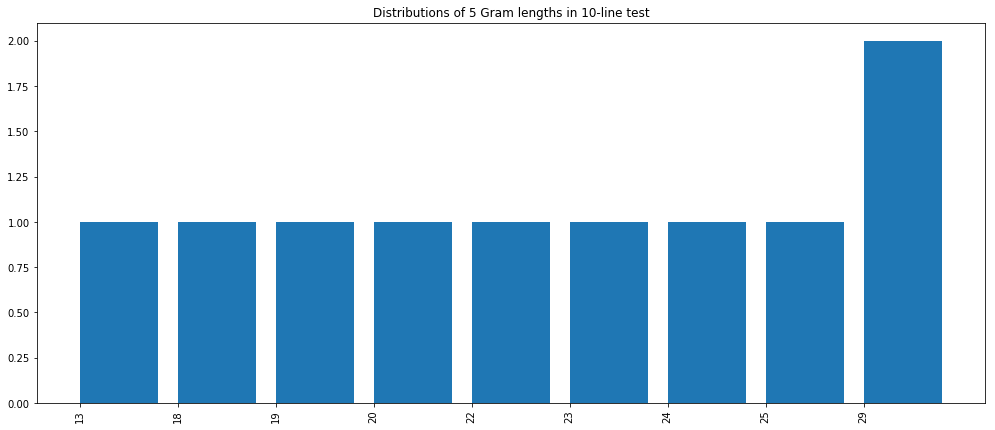

In [55]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("5.3distributions_test").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)
ax.invert_xaxis()


pl.title("Distributions of 5 Gram lengths in 10-line test")
pl.show()

__On the full data set:__

In [56]:
!hdfs dfs -rm -r full_distribution_5.4.1.d
!python distribution.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > full_distribution_5.4.1.d


rm: `full_distribution_5.4.1.d': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/distribution.nhaas.20170620.012753.854016
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/distribution.nhaas.20170620.012753.854016/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.reduce.tasks: mapreduce.job.reduces
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/had

### 5 Gram Distribution on Full Set Statistics:

#### Time
* _Run time: 156.67 seconds_

* _Run time: 2.61 minutes_

#### Input/Output statistics
* _Bytes Read: 2156069116_

* _Bytes Written: 619_

#### Cluster Resources
* _Number of Mappers: 191_

* _Number of Reducers: 1_

* _CPU time spent: 3964310_

## Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

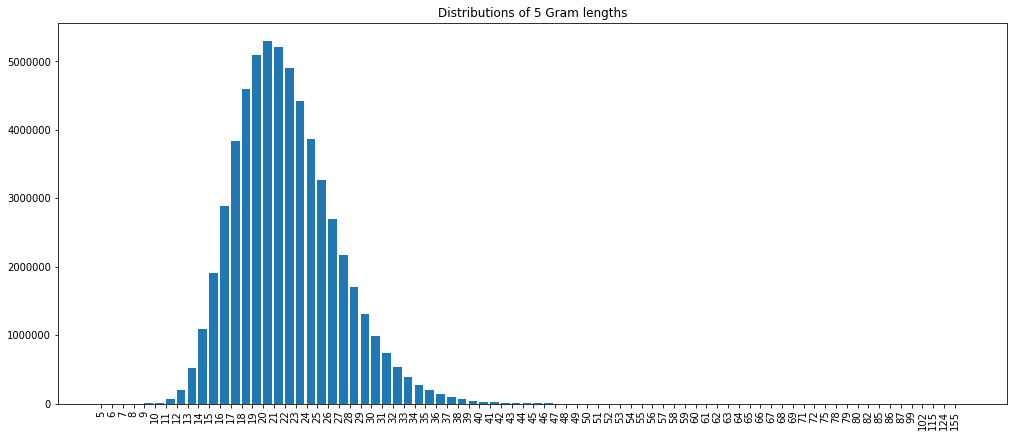

In [58]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("full_distribution_5.4.1.d").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)
ax.invert_xaxis()


pl.title("Distributions of 5 Gram lengths")
pl.show()

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

In [59]:
# START STUDENT CODE 5.5
# ADD OR REMOVE CELLS AS NEEDED

## Frequency ranking

In [60]:
%%writefile frequencies5_5.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import time
import logging

class frequencies(MRJob):

    # START STUDENT CODE 5.4.1.B
    
    MRJob.SORT_VALUES = True
        
    def __init__(self, args):
        super(frequencies, self).__init__(args)
        #self.min_rank = 9001
        #self.max_rank = 10000 
        self.current_rank = 0

    def configure_options(self): 
        super(frequencies, self).configure_options() 
        self.add_passthrough_option('--min_rank', dest='min_rank', type='int', default=9001) 
        self.add_passthrough_option('--max_rank', dest='max_rank', type='int', default=10000) 
    
    def mapper(self, _, line):
        
        # Split line
        splits = line.rstrip("\n").split("\t")
        words = splits[0].lower().split()
        count = int(splits[1])
        
        for word in words:
            yield word, count
            
    
    def combiner(self, word, counts):
        total = sum(count for count in counts)
        yield word, total
    
    def reducer(self, word, counts):
        total = sum(count for count in counts)
        yield total, word
    
    def max_reducer(self, count, words):
        
        # Words come in frequency descending order here
        # Only yield the words that are within the min and max frequency ranking desired
        
        for word in words:
            self.current_rank += 1
            
            if self.current_rank >= self.options.min_rank and self.current_rank <= self.options.max_rank:
                yield word, count

    def steps(self):
        
        custom_jobconf = {
            'stream.num.map.output.key.fields':'2',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1nr',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(mapper=self.mapper,
                    reducer=self.reducer,
                    combiner = self.combiner),
                MRStep(jobconf=custom_jobconf,
                       reducer=self.max_reducer)
                 ]

    # END STUDENT CODE 5.4.1.B
        
if __name__ == '__main__':
    start_time = time.time()
    frequencies.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing frequencies5_5.py


### Frequency ranking on 10-line test dataset

In [61]:
!hdfs dfs -rm -r frequencies_test5.5
!python frequencies5_5.py --min_rank 2 --max_rank 4 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > frequencies_test5.5


rm: `frequencies_test5.5': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/frequencies5_5.nhaas.20170620.013034.143683
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/frequencies5_5.nhaas.20170620.013034.143683/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-strea

### Frequencies on Test Set Statistics:

#### Time
* _Run time: 87.94 seconds_

* _Run time: 1.47 minutes_

#### Input/Output statistics
* _Bytes Read: 536_

* _Bytes Written: 40_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 2480_

In [62]:
!cat frequencies_test5.5

"in"	1201
"wales"	1099
"christmas"	1099


### Frequency ranking on full dataset

In [63]:
!hdfs dfs -rm -r frequencies5.5
!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5


rm: `frequencies5.5': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/frequencies5_5.nhaas.20170620.013204.810165
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/frequencies5_5.nhaas.20170620.013204.810165/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-

Removing HDFS temp directory hdfs:///user/nhaas/tmp/mrjob/frequencies5_5.nhaas.20170620.013204.810165...
Removing temp directory /tmp/frequencies5_5.nhaas.20170620.013204.810165...
    In minutes: 8.13681833347 mins


### Frequencies on Full Set Statistics:

#### Time
* _Run time: 477.21 seconds_

* _Run time: 8.14 minutes_

#### Input/Output statistics
* _Bytes Read: 2156069116_

* _Bytes Written: 4158739_

#### Cluster Resources
* _Number of Mappers: 191_

* _Number of Reducers: 1_

* _CPU time spent: 15443020_

In [64]:
!cat frequencies5.5

"surveys"	169333
"jungle"	169314
"lacked"	169282
"correlate"	169273
"boxes"	169237
"escort"	169220
"disclosed"	169132
"shepherd"	169114
"commend"	169081
"zenith"	169049
"multiplication"	169025
"epic"	169004
"literacy"	168967
"atonement"	168908
"soda"	168897
"necrosis"	168894
"initially"	168891
"compounded"	168832
"compressed"	168825
"bade"	168815
"confidential"	168713
"monitored"	168709
"residing"	168694
"shortcomings"	168632
"disclosure"	168627
"sulphate"	168511
"composite"	168469
"evenly"	168458
"nephew"	168409
"canoe"	168402
"miseries"	168377
"ethic"	168374
"cathode"	168348
"proportionate"	168341
"treats"	168325
"speedily"	168322
"impart"	168307
"stipulated"	168278
"hygiene"	168271
"palestinian"	168244
"convergence"	168145
"maxim"	168097
"schooling"	168053
"annum"	168038
"shrink"	168034
"ribs"	167948
"recognizes"	167929
"ridicule"	167904
"acetic"	167850
"diminishing"	167800
"populous"	167697
"threads"	167685
"protestants"	167678
"hailed"	167633
"completeness"	167597
"spectators"	167

## Stripes

In [65]:
%%writefile stripes5_5.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import collections
import time
import logging

class stripes(MRJob):
  
    #START SUDENT CODE531_STRIPES
  
    MRJob.SORT_VALUES = True
    
    def __init__(self, args):
        self.valid_words = set()
        super(stripes, self).__init__(args)
    
    def mapper_init(self):
        # Load the left table in the init so all mappers get this info
        with open("frequencies5.5", 'r') as f:
            for line in f.readlines():
                x = line.strip().split("\t")
                self.valid_words.add(x[0].strip("\""))
            
    
    def mapper(self, _, line):
        splits = line.rstrip("\n").split("\t")

        words = splits[0].lower().split()
        count = splits[1]

        H = {}
        for subset in itertools.combinations(sorted(set(words)), 2):
            
            # Logic from slack discussion, with Sharmila and Kyle: the stripes are assymentric
            # If a given word is a valid word, then we build a stripe for the other word and add
            # its co-ocurrence to the valid word. If both words are valid, only then we add
            # to stripes in a symmetric way
            
            if subset[1] in self.valid_words:

                # Process combinations in sorted order, i.e. "hello","tomorrow"
                if subset[0] not in H.keys():
                    H[subset[0]] = {}
                    H[subset[0]][subset[1]] = count 
                elif subset[1] not in H[subset[0]]:
                    H[subset[0]][subset[1]] = count
                else:
                    H[subset[0]][subset[1]] += count

            if subset[0] in self.valid_words:
                # Obtain combinations in reverse order
                if subset[1] not in H.keys():
                    H[subset[1]] = {}
                    H[subset[1]][subset[0]] = count 
                elif subset[0] not in H[subset[1]]:
                    H[subset[1]][subset[0]] = count
                else:
                    H[subset[1]][subset[0]] += count
                    
        for key in H.keys():
            yield key, H[key]

    def reducer(self, key, values):
        
        counter = {}

        for value in values:
            
            for k, v in value.iteritems():
                if k in counter:
                    counter[k] += int(v)
                else:
                    counter[k] = int(v)
        
        yield key, counter

  #END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
    start_time = time.time()
    stripes.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing stripes5_5.py


In [66]:
!hdfs dfs -rm -r stripes5.5
!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5

rm: `stripes5.5': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/frequencies5_5.nhaas.20170620.014015.768683
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/frequencies5_5.nhaas.20170620.014015.768683/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.

Removing HDFS temp directory hdfs:///user/nhaas/tmp/mrjob/frequencies5_5.nhaas.20170620.014015.768683...
Removing temp directory /tmp/frequencies5_5.nhaas.20170620.014015.768683...
    In minutes: 9.56697226763 mins


### Frequencies 5_5 on Full Set Statistics:

#### Time
* _Run time: 574.02 seconds_

* _Run time: 9.57 minutes_

#### Input/Output statistics
* _Bytes Read: 4176522_

* _Bytes Written: 17944_

#### Cluster Resources
* _Number of Mappers: 2_

* _Number of Reducers: 1_

* _CPU time spent: 13180_

In [67]:
!cat stripes5.5

cat: stripes5.5: No such file or directory


## Inverted Index

In [68]:
%%writefile index5_5.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-


from __future__ import division
import collections
import re
import json
import math
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import json
import time
import logging

class index(MRJob):
    
    #START SUDENT CODE531_INV_INDEX
  
    def mapper(self, _, line):
        key, stripeJson = line.strip().split('\t')
        key = key.strip("\"")
        stripe = json.loads(stripeJson)
        
        for k, v in stripe.iteritems():
            yield k, [key, len(stripe)]
        
    def reducer(self, key, values):

        table = {}
        for value in values:
            table[value[0]] = value[1]
            
        yield key, table
        
    #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    start_time = time.time()
    index.run() 
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing index5_5.py


In [69]:
!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5


rm: `index5.5': No such file or directory
No configs found; falling back on auto-configuration
Traceback (most recent call last):
  File "index5_5.py", line 43, in <module>
    index.run() 
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/job.py", line 429, in run
    mr_job.execute()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/job.py", line 447, in execute
    super(MRJob, self).execute()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/launch.py", line 158, in execute
    self.run_job()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/launch.py", line 228, in run_job
    runner.run()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/runner.py", line 481, in run
    self._run()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/site-packages/mrjob/hadoop.py", line 332, in _run
    self._check_input_exists()
  File "/home/nhaas/.conda/envs/my_env/lib/python2.7/s

### Index 5_5 on Stripes5.5 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [70]:
!cat index5.5

## Similarity

In [71]:
%%writefile similarity5_5.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
#import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import time
import logging

class similarity(MRJob):
  
    #START SUDENT CODE531_SIMILARITY

    MRJob.SORT_VALUES = True
    
    def mapper(self, _, line):
        key, valuesJson = line.strip().split('\t')
        key = key.strip("\"")
        values = json.loads(valuesJson)

        for pair in itertools.combinations(sorted(set(values)), 2):
            yield pair, [values[pair[0]], values[pair[1]]]
        
    def reducer(self, key, values):
        intersection = 0
        count1 = None
        count2 = None
        
        cosine = 0.0
        
        # Iterate through the values
        for value in values:
            # Jaccard, get counts for the intersection, and for each set
            intersection += 1
            if count1 == None:
                count1 = value[0]
                count2 = value[1]
        
            # Cosine
            a = 1 / math.sqrt(value[0])
            b = 1 / math.sqrt(value[1])
            cosine += a * b
            
        jaccard = float(intersection) / float(count1 + count2 - intersection)
        
        overlap_coefficient = float(intersection) / min(count1, count2)
        
        dice_coefficient = float(2 * intersection) / (count1 + count2)
        
        average = (cosine + jaccard + overlap_coefficient + dice_coefficient) / 4.0
        
        yield average, [key[0] + ' - ' + key[1], cosine, jaccard, overlap_coefficient, dice_coefficient, average]
    
    
    def max_reducer(self, average, records):
        for record in records:
            yield average, record

    def steps(self):
        
        custom_jobconf = {
            'stream.num.map.output.key.fields':'2',
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1,1nr',
            'mapred.reduce.tasks': '1'
        }

        return [
                MRStep(mapper=self.mapper,
                    reducer=self.reducer),
                MRStep(jobconf=custom_jobconf,
                       reducer=self.max_reducer)
                 ]
    
    #END SUDENT CODE531_SIMILARITY
  
if __name__ == '__main__':
    start_time = time.time()
    similarity.run()
    elapsed_time = time.time() - start_time
    mins = elapsed_time/float(60)
    a = """Elapsed time: %s seconds
    In minutes: %s mins""" % (str(elapsed_time), str(mins))
    logging.warning(a)

Writing similarity5_5.py


In [72]:
!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5


rm: `similarity5.5': No such file or directory
No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity5_5.nhaas.20170620.014955.280458
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/nhaas/tmp/mrjob/similarity5_5.nhaas.20170620.014955.280458/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7

### Similarity 5_5 on Index 5.5 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [77]:
!cat similarity5.5

In [74]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [75]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [76]:
import nltk
nltk.download()

ImportError: No module named nltk

In [ ]:
# END STUDENT CODE 5.5

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )


In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [ ]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
import time
import logging

#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits
start_time = time.time()
top1000sims = []
with open("sims2/top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

elapsed_time = time.time() - start_time
mins = elapsed_time/float(60)
a = """Elapsed time: %s seconds
In minutes: %s mins""" % (str(elapsed_time), str(mins))
logging.warning(a)   

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

## 3.  HW5.7  <a name="5.7"></a> OPTIONAL: using different vocabulary subsets
[Back to Table of Contents](#TOC)


Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

### 5.7: Vocabulary subset 8001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 8001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 7001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 7001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 7000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 7000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 7000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 7000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 6001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 6001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 6000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 6000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 6000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 6000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 5001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 5001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 5000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 5000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 5000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 5000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 4001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 4001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 4000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 4000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 4000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 4000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 3001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 3001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 3000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 3000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 3000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 3000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 2001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 2001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 2000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 2000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 2000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 2000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

### 5.7: Vocabulary subset 1001-10000

In [ ]:
!hdfs dfs -rm -r frequencies5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5
!python frequencies5_5.py --min_rank 1001 --max_rank 10000 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > frequencies5.5

!hdfs dfs -rm -r stripes5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python stripes5_5.py --file=frequencies5.5 -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered.txt > stripes5.5

!hdfs dfs -rm -r index5.5
!python index5_5.py -r hadoop stripes5.5 > index5.5

!hdfs dfs -rm -r similarity5.5
#!python frequencies5_5.py -r hadoop hdfs:///user/cendylin/filtered-5Grams/ > frequencies5.5'
!python similarity5_5.py -r hadoop index5.5 > similarity5.5

### Frequencies on Vocab Subset 1000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _


### Stripes on Vocab Subset 1000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Index on Vocab Subset 1000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

### Similarity on Vocab Subset 1000-10000 Set Statistics:

#### Time
* _Run time: - seconds_

* _Run time: - minutes_

#### Input/Output statistics
* _Bytes Read: - _

* _Bytes Written: - _

#### Cluster Resources
* _Number of Mappers: - _

* _Number of Reducers: - _

* _CPU time spent: - _

In [ ]:
import json

sortedSims = []
with open("similarity5.5","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        sortedSims.append(lisst)

In [ ]:
!mkdir sims2
!head -1000 similarity5.5 > sims2/top1000sims

In [ ]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

## 3.  HW5.8  <a name="5.8"></a> OPTIONAL: filter stopwords
[Back to Table of Contents](#TOC)

There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



## 3.  HW5.9 <a name="5.9"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## 3.  HW5.10 <a name="5.10"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?